In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from sklearn.preprocessing import scale
from sklearn.linear_model import enet_path
from sklearn.ensemble import RandomForestRegressor

In [2]:
# load data for NO2, SO2, PM2.5 and CO (January 2018 to July 2022) that has had
# January 2018 to November 2020 Openweathermap.org data backfilled and output as csv's
# using jupyter notebook code from mx3.ipynb
df_no2 = pd.read_csv('no2_api_backfill.csv')
df_so2 = pd.read_csv('so2_api_backfill.csv')
df_pm = pd.read_csv('pm_api_backfill.csv')
df_co = pd.read_csv('co_api_backfill.csv')

In [3]:
# resolve different name in economic data csv file
df_no2 = df_no2.rename(columns={'NO2_Vijaywada': 'NO2_Vijayawada'})
df_so2 = df_so2.rename(columns={'SO2_Vijaywada': 'SO2_Vijayawada'})
df_pm = df_pm.rename(columns={'PM2_5_Vijaywada': 'PM2_5_Vijayawada'})
df_co = df_co.rename(columns={'CO_Vijaywada': 'CO_Vijayawada'})

In [4]:
# function to help make list of all 54 city names
def pull_out_city_name_after_(city):
    i = city.find('_')
    return city[i+1:]

In [5]:
# make list of cities using columns of one of the dataframes
city_list = [pull_out_city_name_after_(city) for city in list(df_no2.columns)[1:]]

In [6]:
# load economic (unemployment rate) data for one city
# note: there is no data for 12-31-17 (although this isn't part of the 2018-22 data needed)
df_agartala = pd.read_csv('air_quality_macrox/unemployment_IN/unemployment_IN_Agartala.csv')

In [7]:
# change type of 'date' column to datetime
df_agartala['Date'] = pd.to_datetime(df_agartala['Date'])

In [8]:
# extract out Date series
date_series = df_agartala['Date'][df_agartala['Date'] >= '2018-01-01']

In [9]:
# define path to Indian economic data directories
# assumption: initial current working directory has "air_quality_macrox" in it
path = "air_quality_macrox/unemployment_IN"
# make working directory "unemployment_IN"
os.chdir(path)

In [10]:
# find cities with missing unemployment rate data
for city in city_list:
    df = pd.read_csv(f'unemployment_IN_{city}.csv')
    # change type of 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # keep data only 2018 and after
    df = df[df['Date'] >= '2018-01-01']
    if(df.shape[0] < 55):
        print(f'df shape: {df.shape} and city: {city}')

df shape: (54, 6) and city: Dehradun
df shape: (38, 6) and city: Gangtok
df shape: (54, 6) and city: Srinagar


In [11]:
# remove the cities that have incomplete economic data
# note: Dehradun data will be used to test the model derived from a nearby city
# since this data will not be used for modeling initially
# Gangtok and Sringer are located away from the other cities with distinct geographic characteristics
if 'Dehradun' in city_list: city_list.remove('Dehradun')
if 'Gangtok' in city_list: city_list.remove('Gangtok')
if 'Srinagar' in city_list: city_list.remove('Srinagar')

In [12]:
# make a list of series containing unemployment rates for each of the 54 cities
city_series_list = []
for city in city_list:
    df = pd.read_csv(f'unemployment_IN_{city}.csv')
    # change type of 'Date' column to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # keep data only 2018 and after
    df = df[df['Date'] >= '2018-01-01']
    # pull out "Unemployment" column as series and rename with the city
    unemployment_series = df.filter(like='Unemployment', axis=1).iloc[:,0].rename(f'rate_{city}')
    city_series_list.append(unemployment_series.reset_index(drop=True))
# create dataframes, concatenating all the individual pandas series
df_unempl_rate = pd.concat(city_series_list, axis=1)

In [13]:
# export df_unemployment rate for possible further analysis
df_unempl_rate.to_csv('city_unemployment_rates.csv', encoding='utf-8', index=False)

In [14]:
pollutant_dates = pd.to_datetime(df_no2['date'])

In [15]:
# Note: the optimal value of hyperparameters as a function of the number of iterations could 
# be plotted to show convergence of average values.

def rf_hyperparam_grid_search(X, y, md_list, msl_list, number_of_iterations=20):
    """ 
        finds the optimal hyperparameter values for:
        md_list: the maximum depth of the tree - list of int
        msl_list: minimum samples in a leaf - list of int
        Note:
        X: data matrix, columns as features
        y: 1 dimensional array of response values
        If the sample size is low, the optimal hyperparameters will be very
        sensitive to the random selection of data points
        during the boot strap sampling step. Averaging over many iteration
        will lead to a more accurate selection
    """
    optimal_param_arr = np.zeros((number_of_iterations, 2))
    for ii, rand_seed in enumerate(range(number_of_iterations)):
        oob_arr = np.zeros((len(md_list), len(msl_list)))
        for jj, md in enumerate(md_list):
            for kk, msl in enumerate(msl_list):
                rf = RandomForestRegressor(max_depth=md,
                                           random_state=rand_seed,
                                           max_features='sqrt',
                                           min_samples_leaf=msl,
                                           oob_score=True).fit(X, y)
                oob_arr[jj,kk] = rf.oob_score_
        # find indices of maximum oob_score (# a large oob score is better)
        i,j = np.unravel_index(oob_arr.argmax(), oob_arr.shape)
        # save these two optimal parameter values
        optimal_param_arr[ii] = np.array([md_list[i], msl_list[j]])
    # select the mean value of hyperparameter and return as int (after rounding)
    md  = np.rint(np.mean(optimal_param_arr[:,0])).astype(int)
    msl = np.rint(np.mean(optimal_param_arr[:,1])).astype(int)
    return (md, msl)

In [16]:
# define thresholds for pollutants
threshold_no2 = 40
threshold_so2 = 40
threshold_pm = 30
threshold_co = 1000
# initialize list to store sparcity information after applying a threshold to the data
percent_nonzero_after_threshold = []

# initialize list of models for each of the 51 cities
hyperparameter_arr = np.zeros((len(city_list), 2))
city_model_list = []

for ii, city in enumerate(city_list):
    # create X (feature matrix)
    X = np.hstack((df_no2.filter(like=city, axis=1).to_numpy(),
                   df_so2.filter(like=city, axis=1).to_numpy(),
                   df_pm.filter(like= city, axis=1).to_numpy(),
                   df_co.filter(like= city, axis=1).to_numpy()))
    # apply thresholds to each column of feature matrix X
    X[:,0][X[:,0] < threshold_no2] = 0.0
    X[:,1][X[:,1] < threshold_so2] = 0.0
    X[:,2][X[:,2] < threshold_pm] = 0.0
    X[:,3][X[:,3] < threshold_co] = 0.0
    # scale all elements to units of corresponding thresholds
    # therefore divide each column by its threshold
    # note: zero elements should remain zero
    X[:,0] = X[:,0] / threshold_no2
    X[:,1] = X[:,1] / threshold_so2
    X[:,2] = X[:,2] / threshold_pm
    X[:,3] = X[:,3] / threshold_co
    # record proportion of non-zero entries after applying threshold
    percent_nonzero_after_threshold.append(np.count_nonzero(X)/(X.shape[0] * X.shape[1]))
    # Make X into dataframe so that pandas groupby can be used
    df_X = pd.DataFrame(X)
    # insert the date so that it can be a key used for Grouper
    df_X.insert(0,'date',pollutant_dates)
    # for each month, sum up the over threshold days scaled by
    # the thresholds themselves. If the threshold is 80 and an entry
    # is 120, that days entry will be 1.5
    df_X = df_X.groupby(pd.Grouper(key='date', freq='1M')).sum()
    # create new feature matrix X with monthly data points
    X = df_X.to_numpy()
    assert X.shape == (55,4), f'for {city} matrix shape: {X.shape} not equal to (55,4)'
    # Add new features: the one month change in the pollutant concentration
    # This will result in one less row for the overall feature data matrix
    X_delta = X[1:,:] - X[:54,:]
    # combine new difference features with original features
    X_e = np.hstack((X[1:,:], X_delta))
    assert X_e.shape == (54,8), f'for {city} matrix shape: {X_e.shape} not equal to (54,8)'
    # create response, y - monthly unemployment data
    y = df_unempl_rate.filter(like=city, axis=1).to_numpy().flatten()
    # remove 1st data point of y to be compatible with X_e containing the difference features
    y_e = y[1:]
    # Set up hyperparameter optimization using mse from predictions for validation set
    # max_depth (maximum depth of the tree) values
    md_list = [5,6,7,8,9]
    # min_samples_leaf (the minimum number of samples to be a leaf node) values
    msl_list = [1,2,3,4,5]
    # find optimal hyperparameter for random forest with grid search
    md, msl = rf_hyperparam_grid_search(X=X_e,
                                        y=y_e,
                                        md_list=[5,6,7,8,9],
                                        msl_list=[1,2,3,4,5],
                                        number_of_iterations=20)
    hyperparameter_arr[ii] = np.array([md, msl])
    # create 10 random forest models for the city (since sample size is small)
    # and store them in a list ("city_model_list")
    rf_list = []
    for random_number in range(10):
        rf = RandomForestRegressor(max_depth=md,
                                   random_state=random_number,
                                   max_features='sqrt',
                                   min_samples_leaf=msl,
                                   oob_score=True).fit(X_e, y_e)
        rf_list.append(rf)

    city_model_list.append(rf_list)

In [17]:
os.chdir('..')
os.chdir('..')

In [18]:
city_series = pd.Series(city_list, name='city')

In [19]:
# export the percent of nonzero values in data matrix after applying rectifier function for each city's data
df_percentage = pd.DataFrame(pd.Series(percent_nonzero_after_threshold, name='percentage'))
df_percentage.insert(loc=0, column='city', value=city_series)
df_percentage.to_csv('percent_nonzero_after_rectifier.csv', encoding='utf-8', index=False)

In [20]:
# export the random forest optimal hyperparameter used for the models for each city
df_hyper = pd.DataFrame(hyperparameter_arr, columns=['max_depth', 'min_samples_leaf'])
df_hyper.insert(loc=0, column='city', value=city_series)
df_hyper.to_csv('random_forest_hyperparameters.csv', encoding='utf-8', index=False)

In [21]:
# export oob score for each city, 10 models per city
oob_score_array = np.zeros((51,10))
for ii, city_model in enumerate(city_model_list):
    for jj, rf_model in enumerate(city_model):
        oob_score_array[ii,jj] = rf_model.oob_score_
        
df_oob = pd.DataFrame(oob_score_array)
df_oob.insert(loc=0, column='city', value=city_series)
df_oob.to_csv('random_forest_oob_scores.csv', encoding='utf-8', index=False)

In [22]:
def consolidate_feature_importance(rf_model_list):
    """
       rf_model_list: a list of random forest models
       returns the percentage importance of the features averaged
       over 10 runs with different random number seeds and returns the standard
       deviation of the feature importances
    """
    importance_matrix = np.zeros((10,8))
    for ii, model in enumerate(rf_model_list):
        importance_matrix[ii] = (model.feature_importances_ / np.max(model.feature_importances_))*100
    return (np.mean(importance_matrix, axis=0), np.std(importance_matrix, axis=0))

In [23]:
# create an array with all the averaged feature importances for each city
# and and array with all the standard deviations of the feature importances for city
importance_arr = np.zeros((len(city_list), 8))
importance_std_dev_arr = np.zeros((len(city_list), 8))
for ii, city_models in enumerate(city_model_list):
    importance_arr[[ii]] = consolidate_feature_importance(city_models)[0]
    importance_std_dev_arr[ii] = consolidate_feature_importance(city_models)[1]

In [24]:
# create dataframes for importance arrays and export
df_importance = pd.DataFrame(importance_arr,
                             columns=['NO2','SO2','PM2_5','CO','delta_NO2','delta_SO2','delta_PM2_5','delta_CO'])
df_importance.insert(loc=0, column='city', value=city_series)

df_importance_std_dev = pd.DataFrame(importance_std_dev_arr,
                             columns=['NO2','SO2','PM2_5','CO','delta_NO2','delta_SO2','delta_PM2_5','delta_CO'])
df_importance_std_dev.insert(loc=0, column='city', value=city_series)

df_importance.to_csv('random_forest_importance.csv', encoding='utf-8', index=False)
df_importance_std_dev.to_csv('random_forest_std_dev_importance.csv', encoding='utf-8', index=False)

In [25]:
# investigate Dehradun as a city to test the model from Chandigarh
df = pd.read_csv('air_quality_macrox/unemployment_IN/unemployment_IN_Dehradun.csv')
# change type of 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
# keep data only 2018 and after
df = df[df['Date'] >= '2018-01-01']
# pull out "Unemployment" column as series and rename with the city
unemployment_series = df.filter(like='Unemployment', axis=1).iloc[:,0].rename(f'rate_Dehradun')
y_dehradun = np.array(unemployment_series)

In [26]:
# process Dehradun data the same way as other cities to create feature matrix
# create X (feature matrix)
X = np.hstack((df_no2.filter(like='Dehradun', axis=1).to_numpy(),
               df_so2.filter(like='Dehradun', axis=1).to_numpy(),
               df_pm.filter(like= 'Dehradun', axis=1).to_numpy(),
               df_co.filter(like= 'Dehradun', axis=1).to_numpy()))
# apply thresholds to each column of feature matrix X
X[:,0][X[:,0] < threshold_no2] = 0.0
X[:,1][X[:,1] < threshold_so2] = 0.0
X[:,2][X[:,2] < threshold_pm] = 0.0
X[:,3][X[:,3] < threshold_co] = 0.0
# scale all elements to units of corresponding thresholds
# therefore divide each column by its threshold
# note: zero elements should remain zero
X[:,0] = X[:,0] / threshold_no2
X[:,1] = X[:,1] / threshold_so2
X[:,2] = X[:,2] / threshold_pm
X[:,3] = X[:,3] / threshold_co
# record proportion of non-zero entries after applying threshold
print(f'nonzero entry proportion: {np.count_nonzero(X)/(X.shape[0] * X.shape[1])}')
# Make X into dataframe so that pandas groupby can be used
df_X = pd.DataFrame(X)
# insert the date so that it can be a key used for Grouper
df_X.insert(0,'date',pollutant_dates)
# for each month, sum up the over threshold days scaled by
# the thresholds themselves. If the threshold is 80 and an entry
# is 120, that days entry will be 1.5
df_X = df_X.groupby(pd.Grouper(key='date', freq='1M')).sum()
# create new feature matrix X with monthly data points
X = df_X.to_numpy()
assert X.shape == (55,4), f'for Dehradun matrix shape: {X.shape} not equal to (55,4)'
# Add new features: the one month change in the pollutant concentration
# This will result in one less row for the overall feature data matrix
X_delta = X[1:,:] - X[:54,:]
# combine new difference features with original features
X_e = np.hstack((X[1:,:], X_delta))
print(X_e.shape)
# remove last row to be compatable with Dehradun missing July 2022 data point
X_e = X_e[:-1]
print(X_e.shape)

nonzero entry proportion: 0.22524009603841535
(54, 8)
(53, 8)


In [27]:
city_list[11]

'Chandigarh'

In [28]:
city_model_list[11][0]

RandomForestRegressor(max_depth=6, max_features='sqrt', min_samples_leaf=2,
                      oob_score=True, random_state=0)

In [29]:
# make predictions for unemployment rate for Dehradun using 10 models trained on
# Chandigarh data
Deh_predictions_arr = np.zeros((10,53))
for ii, model in enumerate(city_model_list[11]):
    Deh_predictions_arr[ii] = model.predict(X_e)
np.mean(Deh_predictions_arr, axis=0)

array([ 7.97676095,  8.99600466,  8.44769097,  8.97013077,  8.92983711,
        8.73833327,  8.97221703,  8.93306109,  9.94555004,  7.89414515,
        9.0671894 ,  9.05469485,  7.81772398,  9.9395387 ,  8.30150197,
        9.05940806,  8.51540404,  8.72733668,  9.09332034,  8.7975227 ,
        9.06123806,  8.91056534,  9.098849  ,  9.05469485,  7.82720044,
        9.06123806,  8.50936654,  8.93886452,  8.73833327,  8.80521309,
        8.87497799,  8.83354772,  9.095921  ,  7.73819925,  9.62302842,
        8.56022654,  9.53920644,  7.54921087,  7.40560849,  9.27860503,
        9.63049331,  7.40560849,  9.12652307,  7.72659489,  9.29173279,
        9.59160137,  7.47507869, 10.94736574,  8.5459429 , 10.07856358,
        7.47123388,  9.95557922,  7.86648765])

In [30]:
series_Deh = pd.Series(y_dehradun[1:], name='rate')
series_Deh_pred = pd.Series(np.mean(Deh_predictions_arr, axis=0), name='predicted_rate')
date_Deh = df['Date'].iloc[1:].reset_index(drop=True)

In [31]:
df_Deh_pred = pd.concat([date_Deh, series_Deh, series_Deh_pred], axis=1)

In [32]:
df_Deh_pred.to_csv('Dehradun_rate_predictions.csv', encoding='utf-8', index=False)

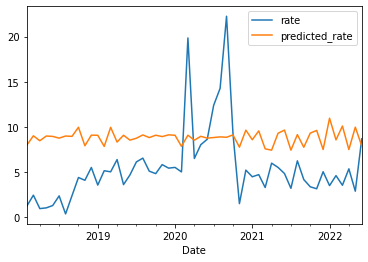

In [33]:
df_Deh_pred.set_index('Date').plot();

In [34]:
df_oob.iloc[:,1:].to_numpy().max(axis=0)

array([0.31216082, 0.32793324, 0.3231877 , 0.31231714, 0.26876222,
       0.3046192 , 0.31632739, 0.29417863, 0.30728015, 0.24506836])